In [ ]:
## Login to HuggingFace with the Access Token

In [3]:
import torch 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from transformers import AutoTokenizer , AutoModelForCausalLM

In [4]:
model_name = "meta-llama/Meta-Llama-3-8B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto"
)

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

2025-08-14 20:55:21.222928: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755204921.480015      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755204921.556114      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/177 [00:00<?, ?B/s]

In [5]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((4096,), eps=1e-05)
    (rotary_

In [6]:
## Visualizing Groups sharing same key values
def vis_gqa_keys(input_text="Hello LLama!",layer_idx=0) : 
    inputs = tokenizer(input_text,return_tensors="pt").to(model.device)

    k_values = []
    def capture_k_hook(module,inputs,output):
        k_values.append(output.detach().cpu())

    layer = model.model.layers[layer_idx]
    k_hook = layer.self_attn.k_proj.register_forward_hook(capture_k_hook)


    with torch.no_grad():
        _=model(**inputs)
    k_hook.remove()
    k = k_values[0]
    batch_size,seq_len,kv_dim = k.shape

    num_q_heads = model.config.num_attention_heads  ## 32
    num_kv_heads = model.config.num_key_value_heads ## 8
    head_dim = kv_dim // num_kv_heads               ## 128
    ## [batch_size,seq_len,num_kv_heads,head_dim] --> [batch_size,num_kv_heads,seq_len,head_dim]
    k_heads = k.reshape(batch_size,seq_len,num_kv_heads,head_dim).transpose(1,2)
    q_to_kv_map = {q: q//(num_q_heads//num_kv_heads) for q in range(num_q_heads)}

    kv_groups = {}
    for q_head , kv_head in q_to_kv_map.items():
        kv_groups.setdefault(kv_head,[]).append(q_head)

    plt.figure(figsize=(20,2.5*len(kv_groups)))
    for row_idx , (kv_id,q_heads) in enumerate(kv_groups.items()):
        for i,q_head in enumerate(q_heads):
            key_matrix=k_heads[0,kv_id,0:1,:20] ## 1st token , first 20 dim
            plt.subplot(len(kv_groups),len(q_heads),row_idx*len(q_heads) +i +1)
            sns.heatmap(key_matrix,cmap="viridis",cbar=False)
            plt.title(f"Group {kv_id} - Q {q_head}",fontsize=10)
            plt.xticks([])
            plt.yticks([])
    plt.suptitle(f"Key Matrix per query head (1st token * 20dim) \ LLama-3-8B Layer {layer_idx}",fontsize=20)
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.savefig(f"LLama-3-8B_Layer{layer_idx}_GQA_keys.png")
    plt.show()

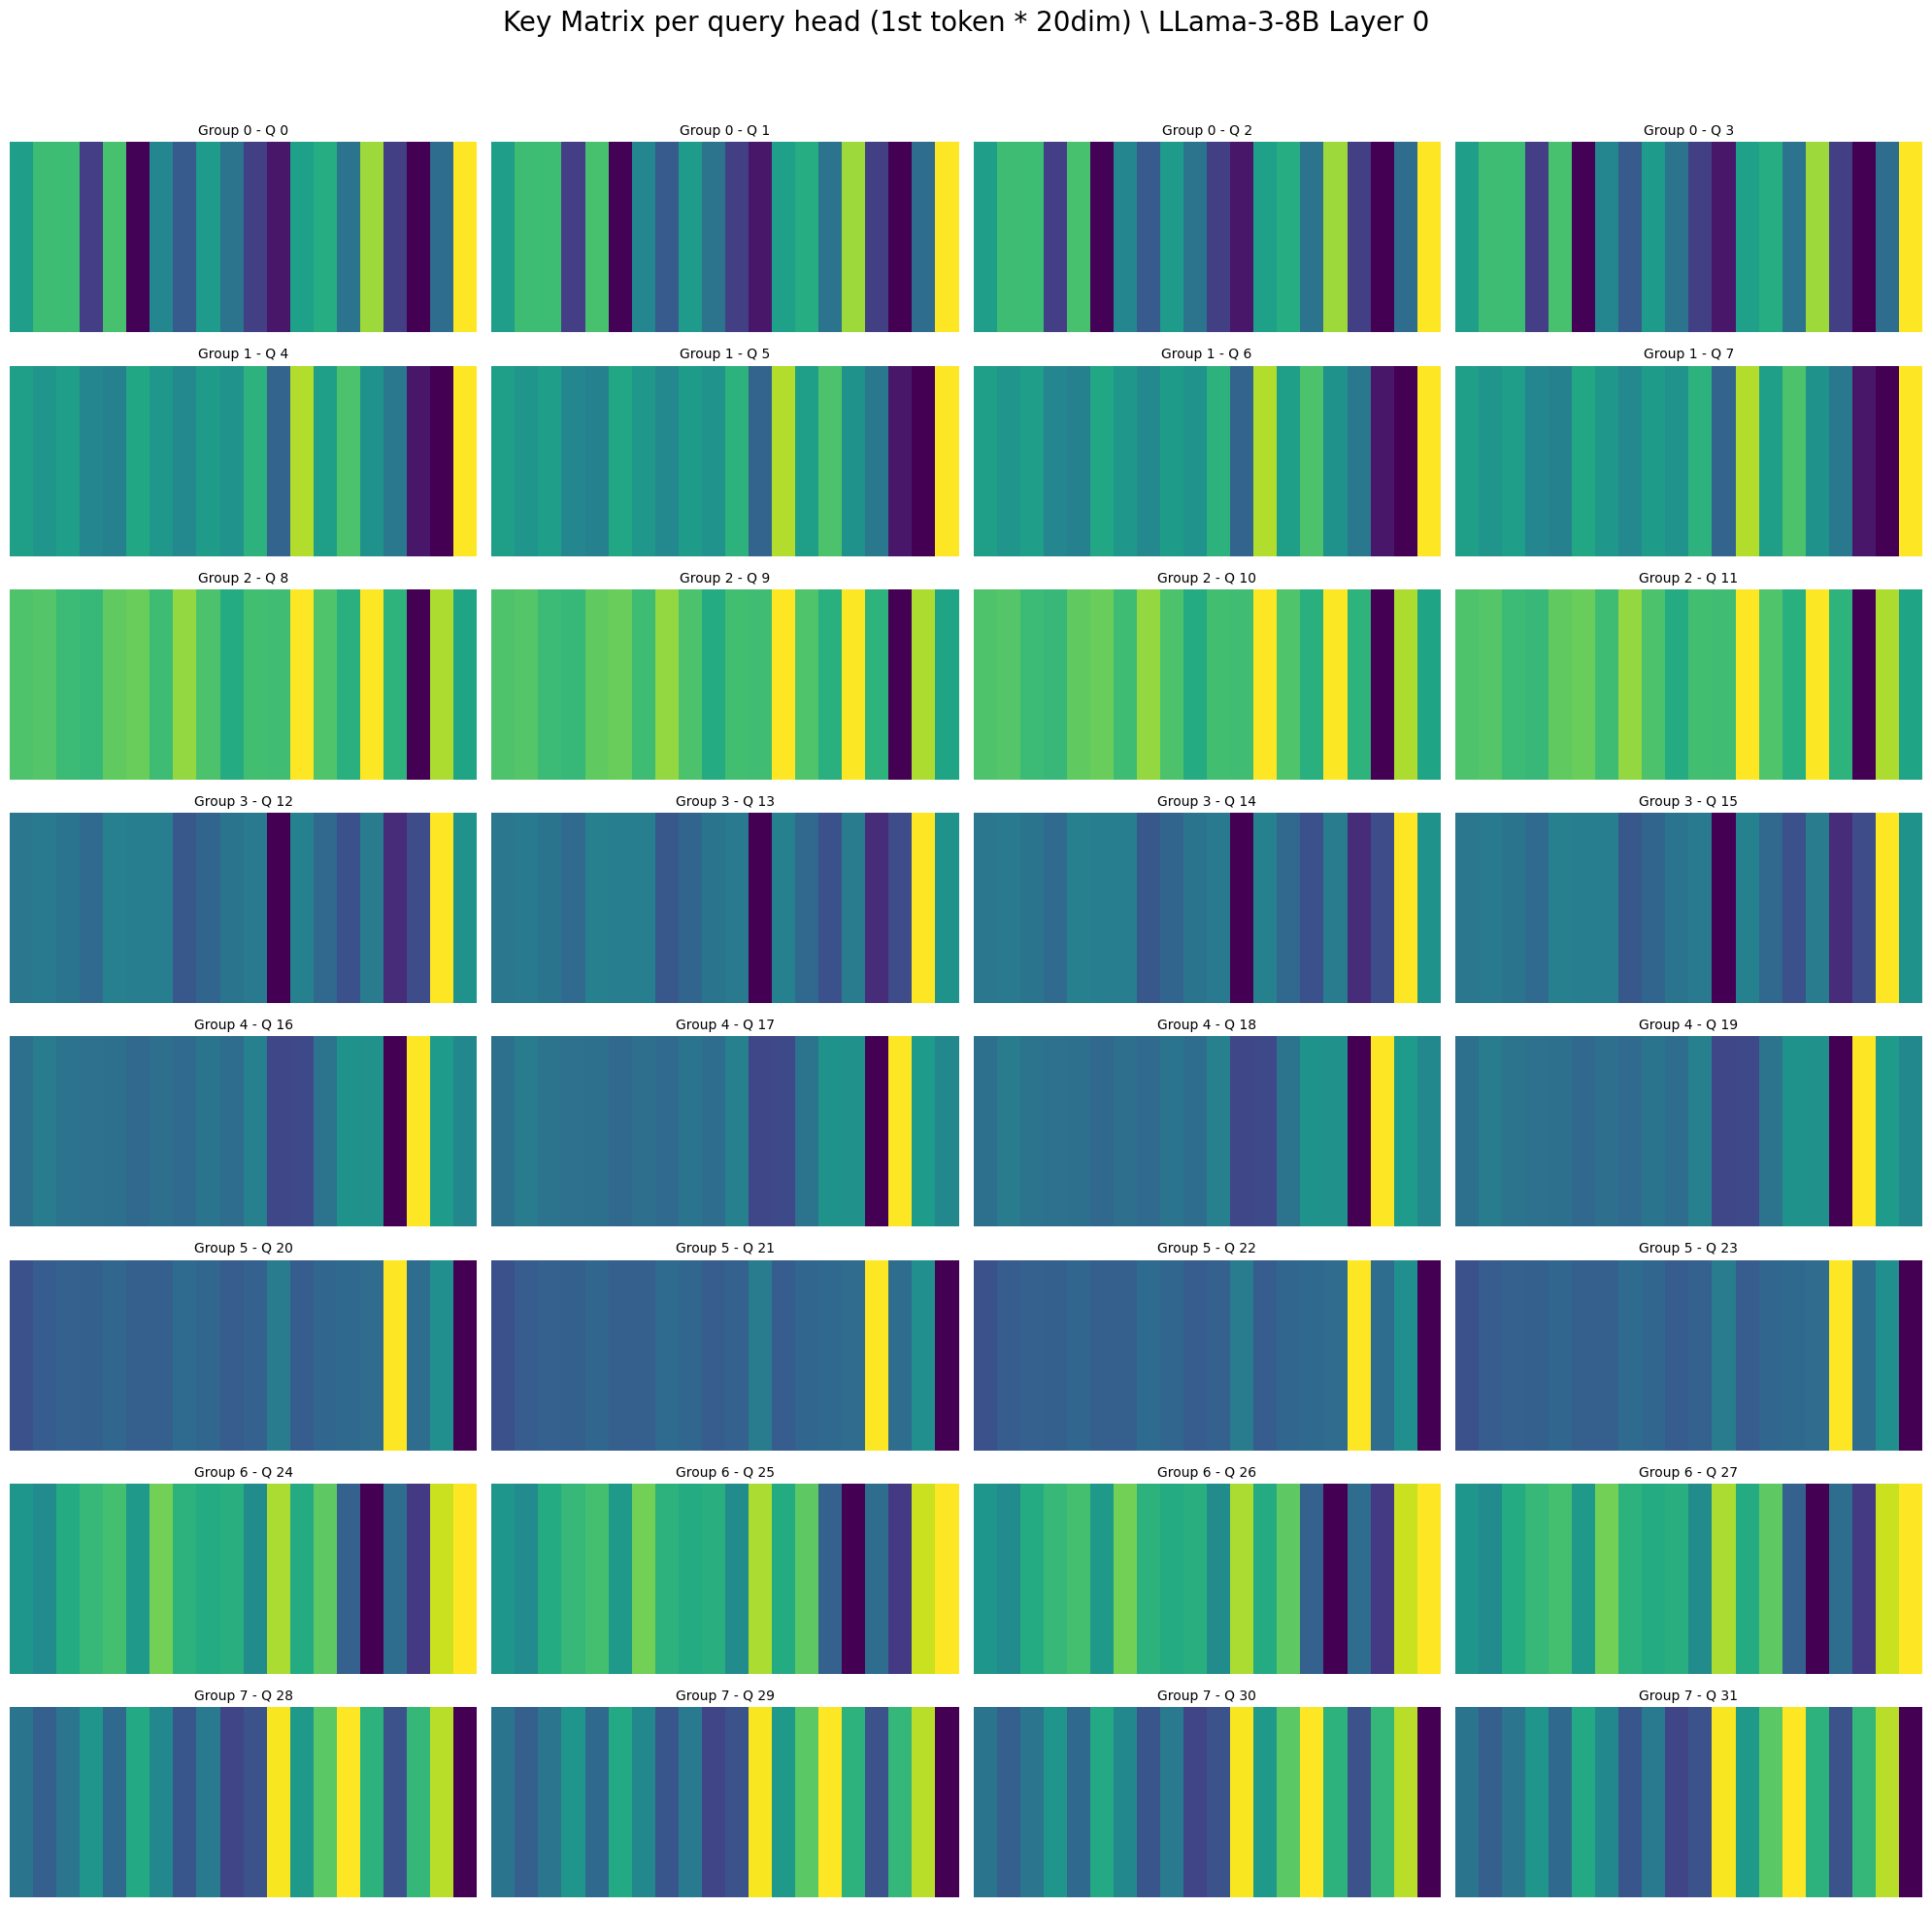

In [7]:
vis_gqa_keys(input_text="Hello LLama!",layer_idx=0)

In [8]:
## Visualizing Groups sharing same key values
def vis_gqa_values(input_text="Hello LLama!",layer_idx=0) : 
    inputs = tokenizer(input_text,return_tensors="pt").to(model.device)

    v_values = []
    def capture_k_hook(module,inputs,output):
        v_values.append(output.detach().cpu())

    layer = model.model.layers[layer_idx]
    v_hook = layer.self_attn.v_proj.register_forward_hook(capture_k_hook)


    with torch.no_grad():
        _=model(**inputs)
    v_hook.remove()
    v = v_values[0]
    batch_size,seq_len,kv_dim = v.shape

    num_q_heads = model.config.num_attention_heads  ## 32
    num_kv_heads = model.config.num_key_value_heads ## 8
    head_dim = kv_dim // num_kv_heads               ## 128
    ## [batch_size,seq_len,num_kv_heads,head_dim] --> [batch_size,num_kv_heads,seq_len,head_dim]
    v_heads = v.reshape(batch_size,seq_len,num_kv_heads,head_dim).transpose(1,2)
    q_to_kv_map = {q: q//(num_q_heads//num_kv_heads) for q in range(num_q_heads)}

    kv_groups = {}
    for q_head , kv_head in q_to_kv_map.items():
        kv_groups.setdefault(kv_head,[]).append(q_head)

    plt.figure(figsize=(20,2.5*len(kv_groups)))
    for row_idx , (kv_id,q_heads) in enumerate(kv_groups.items()):
        for i,q_head in enumerate(q_heads):
            value_matrix=v_heads[0,kv_id,0:1,:20] ## 1st token , first 20 dim
            plt.subplot(len(kv_groups),len(q_heads),row_idx*len(q_heads) +i +1)
            sns.heatmap(value_matrix,cmap="viridis",cbar=False)
            plt.title(f"Group {kv_id} - Q {q_head}",fontsize=10)
            plt.xticks([])
            plt.yticks([])
    plt.suptitle(f"Vlaues Matrix per query head (1st token * 20dim) \ LLama-3-8B Layer {layer_idx}",fontsize=30)
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.savefig(f"LLama-3-8B_Layer{layer_idx}_GQA_keys.png")
    plt.show()

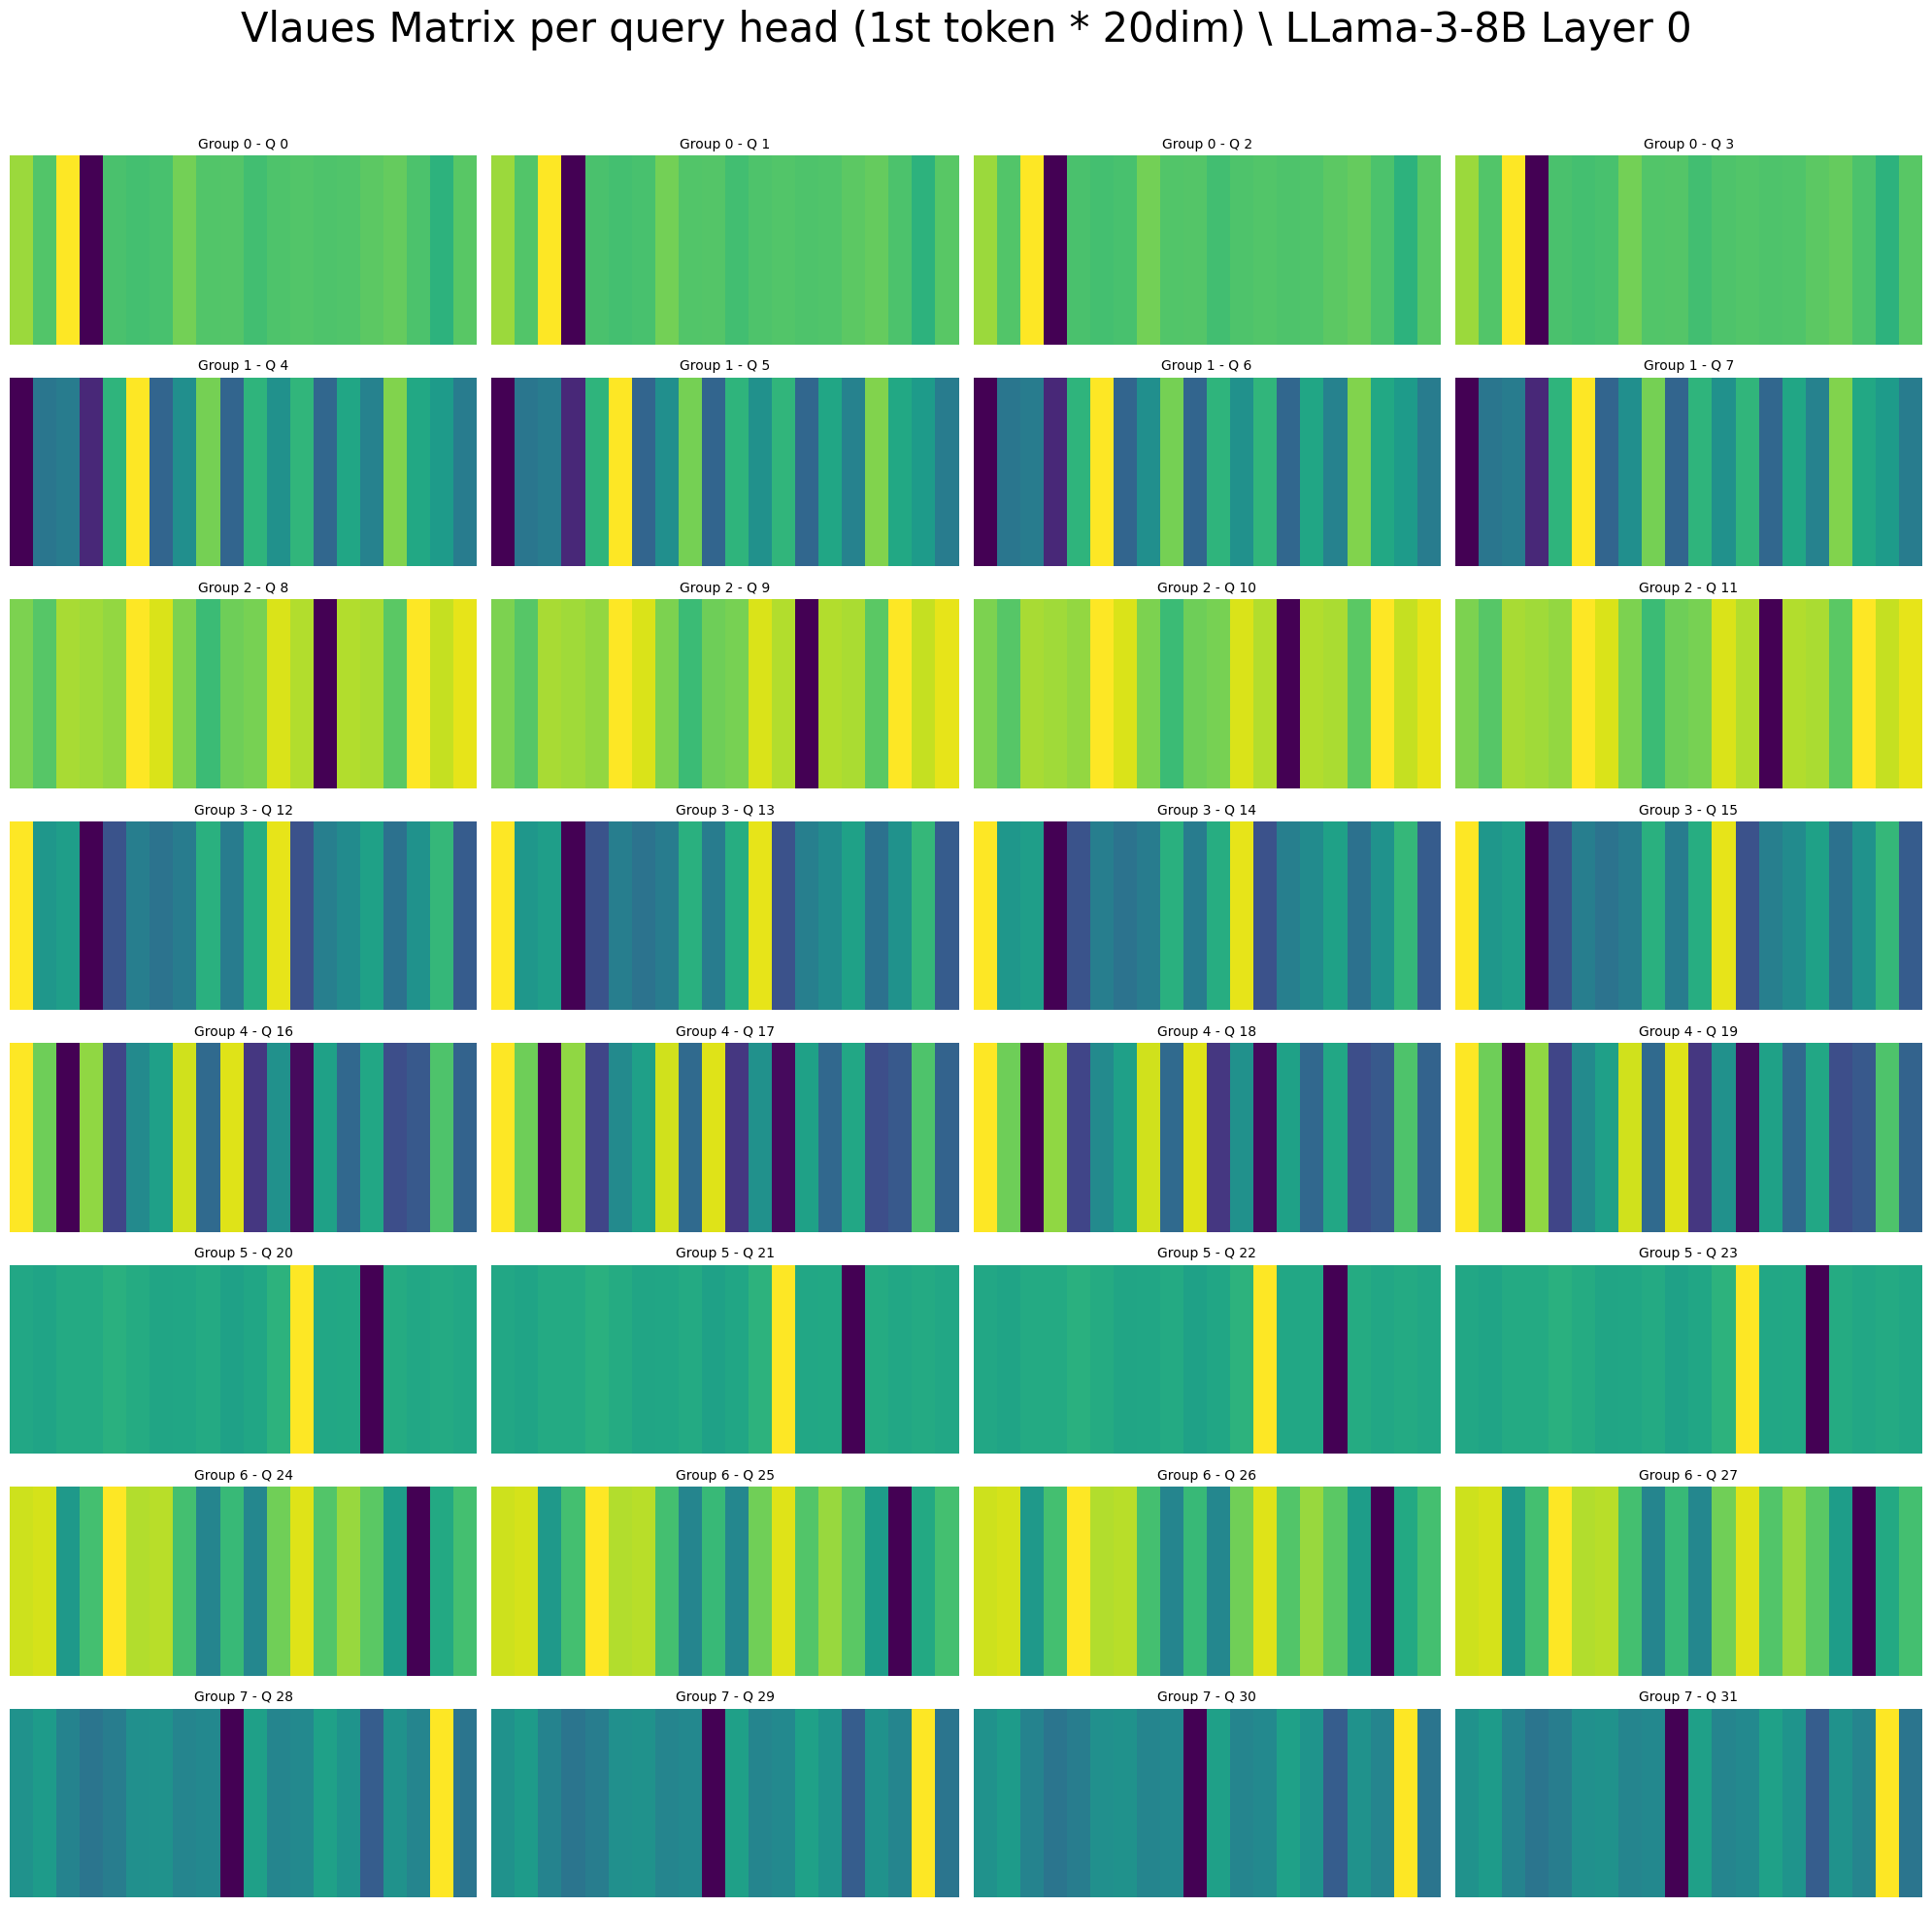

In [9]:
vis_gqa_values(input_text="Hello LLama!",layer_idx=0)